In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from IPython.display import IFrame
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.patches as patches
import warnings
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from IPython.display import IFrame


%matplotlib inline
%load_ext autoreload
%autoreload 2

# IFrame(src='https://commons.pratt.edu/savi/', width=700, height=400)

In [2]:
import urllib

In [3]:
file_url = 'https://s3.amazonaws.com/tripdata/202003-citibike-tripdata.csv.zip'

In [4]:
urllib.request.urlretrieve(file_url, 'data/input/202003-citibike-tripdata.zip')

('data/input/202003-citibike-tripdata.zip',
 <http.client.HTTPMessage at 0x1056fa700>)

In [6]:
import zipfile

In [7]:
zipfile.ZipFile(f'data/input/202003-citibike-tripdata.zip').extractall(f'data/input/')

In [12]:
citibike = pd.read_csv('data/input/202003-citibike-tripdata.csv')

In [20]:
citibike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1589,2020-03-01 00:00:03.6400,2020-03-01 00:26:32.9860,224,Spruce St & Nassau St,40.711464,-74.005524,3574,Prospect Pl & Underhill Ave,40.676969,-73.965790,16214,Subscriber,1980,1
1,389,2020-03-01 00:00:16.7560,2020-03-01 00:06:46.0620,293,Lafayette St & E 8 St,40.730207,-73.991026,223,W 13 St & 7 Ave,40.737815,-73.999947,29994,Subscriber,1991,2


In [23]:
citibike.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

In [31]:
citibike['starttime'] = pd.to_datetime(citibike['starttime'])

In [32]:
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'])

In [44]:
citibike['start_day'] = citibike['starttime'].map(lambda x: x.day)

In [49]:
citibike['end_day'] = citibike['stoptime'].map(lambda x: x.day)

In [50]:
citibike['end_day_2'] = citibike['stoptime'].dt.date

In [52]:
citibike['start_day_2'] = citibike['starttime'].dt.date

In [54]:
citibike['start_hour'] = citibike['starttime'].dt.hour

In [55]:
citibike['end_hour'] = citibike['stoptime'].dt.hour

In [60]:
citibike.shape

(1068457, 21)

## data check- every station only has 1 lat long, for start station and end station

In [61]:
citibike.head(2)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,start_day,end_day,end_day_2,start_day_2,start_hour,end_hour
0,1589,2020-03-01 00:00:03.640,2020-03-01 00:26:32.986,224,Spruce St & Nassau St,40.711464,-74.005524,3574,Prospect Pl & Underhill Ave,40.676969,...,16214,Subscriber,1980,1,1,1,2020-03-01,2020-03-01,0,0
1,389,2020-03-01 00:00:16.756,2020-03-01 00:06:46.062,293,Lafayette St & E 8 St,40.730207,-73.991026,223,W 13 St & 7 Ave,40.737815,...,29994,Subscriber,1991,2,1,1,2020-03-01,2020-03-01,0,0


In [64]:
number_pickups = citibike.groupby(["start station name", "start station latitude" , "start station longitude", "start_day", "start_hour"]).size().to_frame('size').reset_index()

In [98]:
number_pickups

,station name,station latitude,station longitude,day,hour,number_pickups
0,1 Ave & E 110 St,40.792327,-73.938300,1,7,1
1,1 Ave & E 110 St,40.792327,-73.938300,1,11,1
2,1 Ave & E 110 St,40.792327,-73.938300,1,14,3
3,1 Ave & E 110 St,40.792327,-73.938300,1,15,1
4,1 Ave & E 110 St,40.792327,-73.938300,1,21,1
...,...,...,...,...,...,...
291670,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,31,13,1
291671,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,31,17,3
291672,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,31,18,1
291673,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,31,19,2


In [69]:
number_dropoffs = citibike.groupby(["end station name", "end station latitude" , "end station longitude", "end_day", "end_hour"]).size().to_frame('size').reset_index()

In [89]:
number_dropoffs.rename(columns={'end station name' : 'station name',
                                'end station latitude': 'station latitude',
                                'end station longitude': 'station longitude',
                                'end_day':'day',
                                'end_hour': 'hour',
                                'size': 'number_dropoffs'}, inplace=True)

In [92]:
number_pickups.rename(columns={'start station name' : 'station name',
                               'start station latitude': 'station latitude',
                               'start station longitude': 'station longitude',
                               'start_day': 'day',
                               'start_hour': 'hour',
                              'size': 'number_pickups'}, inplace=True)

In [93]:
number_dropoffs.head(2)

,station name,station latitude,station longitude,day,hour,number_dropoffs
0,1 Ave & E 110 St,40.792327,-73.9383,1,0,1
1,1 Ave & E 110 St,40.792327,-73.9383,1,2,2


In [94]:
number_pickups.head(2)

,station name,station latitude,station longitude,day,hour,number_pickups
0,1 Ave & E 110 St,40.792327,-73.9383,1,7,1
1,1 Ave & E 110 St,40.792327,-73.9383,1,11,1


In [95]:
start_complete_test = number_pickups.merge(number_dropoffs,
                                           how='outer',
                                           on=['station name', 'station latitude', 'station longitude',
                                               'day', 'hour'])

In [121]:
start_complete_test.sort_values(by = ['day', 'hour'], ascending=True)

,station name,station latitude,station longitude,day,hour,number_pickups,number_dropoffs
358,1 Ave & E 16 St,40.732219,-73.981656,1,0,4.0,4.0
957,1 Ave & E 18 St,40.733812,-73.980544,1,0,2.0,1.0
1511,1 Ave & E 30 St,40.741444,-73.975361,1,0,1.0,NaN
2961,1 Ave & E 62 St,40.761227,-73.960940,1,0,1.0,1.0
3513,1 Ave & E 68 St,40.765005,-73.958185,1,0,1.0,NaN
...,...,...,...,...,...,...,...
358987,W 76 St & Columbus Ave,40.780184,-73.977285,31,23,NaN,1.0
359751,W Broadway & Spring St,40.724947,-74.001659,31,23,NaN,1.0
359851,Wall St & South St,40.704370,-74.006370,31,23,NaN,2.0
361023,West End Ave & W 94 St,40.794165,-73.974124,31,23,NaN,1.0


## check that outer join works as intended

In [ ]:


start_complete_test[start_complete_test['station name'] == 'Wythe Ave & Metropolitan Ave'].sort_values(by = ['day','hour'], ascending = False).head(8)

In [133]:
citibike[citibike['start station name'] == 
         'Wythe Ave & Metropolitan Ave'].sort_values(by = 'starttime', ascending = False)['starttime'].head(11)

1067766   2020-03-31 21:07:48.489
1067012   2020-03-31 19:51:23.426
1066681   2020-03-31 19:30:42.345
1064909   2020-03-31 18:16:58.916
1064155   2020-03-31 17:51:12.594
1064122   2020-03-31 17:50:06.737
1063108   2020-03-31 17:13:33.555
1058098   2020-03-31 13:06:52.793
1056797   2020-03-31 11:33:57.077
1056300   2020-03-31 10:44:38.808
1056230   2020-03-31 10:36:31.443
Name: starttime, dtype: datetime64[ns]

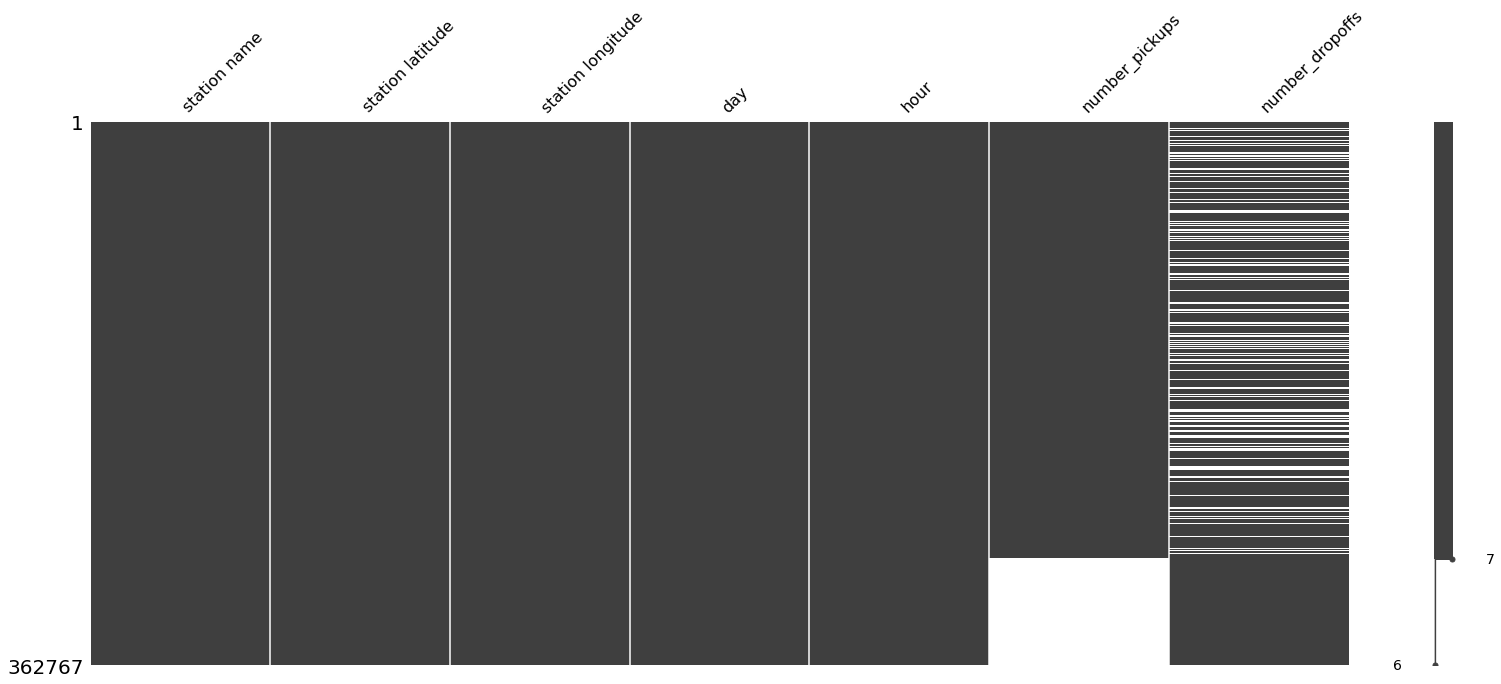

In [97]:
msno.matrix(start_complete_test)

In [177]:
df_citibike = start_complete_test.fillna(0).sort_values(by = ['day','hour','station name'], ascending = True)

In [142]:
from shapely.geometry import Point

In [160]:
# df_citibike['testy'] = df_citibike.apply( lambda row: row['station name'], axis=1)

In [178]:
df_citibike['geometry'] =df_citibike.apply( lambda row: Point(row['station longitude'], row['station latitude'] ), axis=1)

In [168]:
from geopandas import GeoDataFrame

In [179]:
df_citibike = GeoDataFrame(df_citibike, geometry='geometry')
# , crs='epsg:4326')

In [180]:
df_citibike = df_citibike.reset_index()

In [207]:
df_citibike['actitivy'] = df_citibike['number_pickups'] + df_citibike['number_dropoffs']

In [209]:
df_citibike['net_pickups'] = df_citibike['number_pickups'] - df_citibike['number_dropoffs']

In [210]:
df_citibike.head(5)

,index,station name,station latitude,station longitude,day,hour,number_pickups,number_dropoffs,geometry,actitivy,net_pickups
0,291675,1 Ave & E 110 St,40.792327,-73.938300,1,0,0.0,1.0,POINT (-73.93830 40.79233),1.0,-1.0
1,358,1 Ave & E 16 St,40.732219,-73.981656,1,0,4.0,4.0,POINT (-73.98166 40.73222),8.0,0.0
2,957,1 Ave & E 18 St,40.733812,-73.980544,1,0,2.0,1.0,POINT (-73.98054 40.73381),3.0,1.0
3,1511,1 Ave & E 30 St,40.741444,-73.975361,1,0,1.0,0.0,POINT (-73.97536 40.74144),1.0,1.0
4,2961,1 Ave & E 62 St,40.761227,-73.960940,1,0,1.0,1.0,POINT (-73.96094 40.76123),2.0,0.0


In [184]:
df_citibike.shape

(362767, 9)

# Part B: merge with Neighborhoods

In [17]:
nyc_nta_geojson = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'


nta_gdf = gpd.read_file(nyc_nta_geojson)
# nta_gdf.to_crs(epsg=2263, inplace=True)

In [24]:
nta_gdf.head(2)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005019.048,047,Borough Park,39247.2278309,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ..."
1,QN51,52488277.846,081,Murray Hill,33266.9047967,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ..."


In [197]:
nta_gdf.drop(nta_gdf[nta_gdf['boro_name'] == 'Staten Island'].index, inplace=True)

In [198]:
nta_gdf.shape

(176, 8)

### figure out the architecture first

In [204]:
   bikes_in_nyc = gpd.sjoin(  # sjoin stands for spatial join
       
        df_citibike,
       nta_gdf,
        how='left',
        op='intersects',
    )

In [212]:
bikes_in_nyc = bikes_in_nyc.drop(['index'], axis=1)

In [213]:
bikes_in_nyc.head()

,station name,station latitude,station longitude,day,hour,number_pickups,number_dropoffs,geometry,index_right,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code
0,1 Ave & E 110 St,40.792327,-73.938300,1,0,0.0,1.0,POINT (-73.93830 40.79233),179.0,MN34,24494898.4181,061,East Harlem North,30603.7188842,Manhattan,1
1,1 Ave & E 16 St,40.732219,-73.981656,1,0,4.0,4.0,POINT (-73.98166 40.73222),154.0,MN50,5582283.01555,061,Stuyvesant Town-Cooper Village,12021.7903016,Manhattan,1
2,1 Ave & E 18 St,40.733812,-73.980544,1,0,2.0,1.0,POINT (-73.98054 40.73381),154.0,MN50,5582283.01555,061,Stuyvesant Town-Cooper Village,12021.7903016,Manhattan,1
3,1 Ave & E 30 St,40.741444,-73.975361,1,0,1.0,0.0,POINT (-73.97536 40.74144),158.0,MN20,14485874.7728,061,Murray Hill-Kips Bay,24491.3105701,Manhattan,1
4,1 Ave & E 62 St,40.761227,-73.960940,1,0,1.0,1.0,POINT (-73.96094 40.76123),171.0,MN31,21508615.7643,061,Lenox Hill-Roosevelt Island,39424.2257068,Manhattan,1


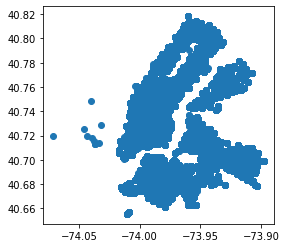

In [211]:
bikes_in_nyc.plot()